### Importing libraries

In [98]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                                roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, 
                                    precision_recall_curve, classification_report)

import warnings
warnings.filterwarnings('ignore')

<b>Problem Statement</b>

Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

Demographics (city, age, gender etc.)<br>
Tenure information (joining date, Last Date)<br>
Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

<b>Column Profiling</b>

1. MMMM-YY : Reporting Date (Monthly)
2. Driver_ID : Unique id for drivers
3. Age : Age of the driver
4. Gender : Gender of the driver – Male : 0, Female: 1
5. City : City Code of the driver
6. Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
7. Income : Monthly average Income of the driver
8. Date Of Joining : Joining date for the driver
9. LastWorkingDate : Last date of working for the driver
10. Joining Designation : Designation of the driver at the time of joining
11. Grade : Grade of the driver at the time of reporting
12. Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
12. Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

<b>Evaluation Metrics</b>

The business case is about finding whether to find the employee gonna churn or not so,

Employee churn = 1 (positve class)<br>
Employee not churn = 0 (negative class)<br>

***Precision = TP / (TP+FP)*** <br>
In precision, we try to reduce FP and focus more on reducing miss-classification of employees, not churn into employee churn (negative class into positive class)

***Recall = TP / (TP+FN)*** <br>
In recall, we try to reduce FN and focus more on reducing miss-classification of employees, churn into employee not churn (positive class into negative class)

Here, in this both precision and recall (more) are important as employeer can loose a employee (churn) if recall is less and if precision is less then the employeer tries to stop who got idea to resign. So we can use F1-score, precision recall curve or RUC AOC curve (let's check later)

### Reading data, and knowing about it's basic info

In [99]:
df = pd.read_csv("https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/492/original/ola_driver_scaler.csv")
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [100]:
print(f"rows, cols = {df.shape}")

rows, cols = (19104, 14)


In [101]:
df.dtypes.reset_index()

,index,0
0,Unnamed: 0,int64
1,MMM-YY,object
2,Driver_ID,int64
3,Age,float64
4,Gender,float64
5,City,object
6,Education_Level,int64
7,Income,int64
8,Dateofjoining,object
9,LastWorkingDate,object


In [102]:
def missing_data_info(df):
    missing_data = pd.DataFrame({
        "feature": df.columns.tolist(),
        "missing_count": df.isna().sum().values
    })

    missing_data["percentage"] = ((missing_data["missing_count"] / df.shape[0]) * 100).round(2)

    display(missing_data)

    print(f"\ntotal number of missing values = {df.isna().sum().sum()}")

missing_data_info(df)

,feature,missing_count,percentage
0,Unnamed: 0,0,0.00
1,MMM-YY,0,0.00
2,Driver_ID,0,0.00
3,Age,61,0.32
4,Gender,52,0.27
5,City,0,0.00
6,Education_Level,0,0.00
7,Income,0,0.00
8,Dateofjoining,0,0.00
9,LastWorkingDate,17488,91.54



total number of missing values = 17601


In [103]:
duplicated_count = df.duplicated().sum()
print(duplicated_count)

0


In [104]:
df.describe(include = "all")

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
count,19104.000000,19104,19104.000000,19043.000000,19052.000000,19104,19104.000000,19104.000000,19104,1616,19104.000000,19104.000000,1.910400e+04,19104.000000
unique,NaN,24,NaN,NaN,NaN,29,NaN,NaN,869,493,NaN,NaN,NaN,NaN
top,NaN,01/01/19,NaN,NaN,NaN,C20,NaN,NaN,23/07/15,29/07/20,NaN,NaN,NaN,NaN
freq,NaN,1022,NaN,NaN,NaN,1008,NaN,NaN,192,70,NaN,NaN,NaN,NaN
mean,9551.500000,NaN,1415.591133,34.668435,0.418749,NaN,1.021671,65652.025126,NaN,NaN,1.690536,2.252670,5.716621e+05,2.008899
std,5514.994107,NaN,810.705321,6.257912,0.493367,NaN,0.800167,30914.515344,NaN,NaN,0.836984,1.026512,1.128312e+06,1.009832
min,0.000000,NaN,1.000000,21.000000,0.000000,NaN,0.000000,10747.000000,NaN,NaN,1.000000,1.000000,-6.000000e+06,1.000000
25%,4775.750000,NaN,710.000000,30.000000,0.000000,NaN,0.000000,42383.000000,NaN,NaN,1.000000,1.000000,0.000000e+00,1.000000
50%,9551.500000,NaN,1417.000000,34.000000,0.000000,NaN,1.000000,60087.000000,NaN,NaN,1.000000,2.000000,2.500000e+05,2.000000
75%,14327.250000,NaN,2137.000000,39.000000,1.000000,NaN,2.000000,83969.000000,NaN,NaN,2.000000,3.000000,6.997000e+05,3.000000


##### Summary:
1. there are 14 features (one label class) and 19104 data points -> which is needed to be cleaned, splitted and trained/validated.
2. there are few date features which are present in object data type -> this can be converted into pd.to_datetime and some insights can be derived
3. missing values are present in age, gender, LastWorkingDay
    - age, gender can be removed (only few missing points) or use KNNImputer to impute
    - LastWorkingDay might be the target class -> let's check later
4. no duplicated data
5. this data is from 29 cities

### Data cleaning and Feature Engineering

In [105]:
df_copy = df.copy()

missing value treatment

In [106]:
df_copy.dropna(subset = ["Gender"], inplace = True)
df_copy.drop("Unnamed: 0", axis = 1, inplace = True)

cols = df_copy.select_dtypes(include=["float64", "int64"]).columns

knn_imputer = KNNImputer(n_neighbors = 5)
df_copy[cols] = knn_imputer.fit_transform(df_copy[cols])
display(df_copy.sample(5))

missing_data_info(df_copy)


,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
16192,08/01/20,2402.0,28.0,0.0,C27,2.0,29150.0,24/07/20,NaN,3.0,3.0,500000.0,1.0
10016,10/01/20,1486.0,45.0,1.0,C15,0.0,81172.0,12/09/16,NaN,1.0,4.0,1158200.0,1.0
8139,03/01/19,1208.0,30.0,0.0,C10,2.0,36558.0,01/08/19,03/09/19,1.0,1.0,0.0,1.0
13744,08/01/20,2049.0,40.0,1.0,C23,1.0,100888.0,24/10/14,NaN,1.0,3.0,0.0,1.0
16893,01/01/20,2494.0,46.0,0.0,C27,0.0,48747.0,25/05/18,NaN,1.0,1.0,799480.0,3.0


,feature,missing_count,percentage
0,MMM-YY,0,0.00
1,Driver_ID,0,0.00
2,Age,0,0.00
3,Gender,0,0.00
4,City,0,0.00
5,Education_Level,0,0.00
6,Income,0,0.00
7,Dateofjoining,0,0.00
8,LastWorkingDate,17441,91.54
9,Joining Designation,0,0.00



total number of missing values = 17441


converting date features into pd.to_datetime

In [107]:
date_cols = [col for col in df_copy.columns if df_copy[col].dtype == "O" and col != "City"]

for col in date_cols:
    df_copy[col] = pd.to_datetime(df_copy[col])

In [108]:
modified_df = df_copy.groupby("Driver_ID").agg({"Income": ["mean","last"], "Total Business Value": [sum,min,max,np.mean,"last"]}).reset_index()

# created a new DataFrame to store each feature value of respective driver

In [109]:
# if the driver churns it maps to 1, else 0

def mapping_func(LastWorkingDate):
    """
    This function takes a date as a parameter,

    if the date is not equal to zero it returns 1 (meaning churn) 
    else returns 0 (no churn)
    
    """
    if LastWorkingDate != 0:
        return 1
    return 0    

In [110]:
# for age, grade, rating we can take current values -> max(age, grade, quarterly rating)
feature_method = {
    "City": "max", 
    "Education_Level": "max", 
    "Dateofjoining": "max", 
    "Joining Designation": "max",
    "Age" : "max", 
    "Grade" : "max", 
    "Quarterly Rating" : "max",
    "Gender" : "max"
}

remaining_data = df_copy.groupby(by = "Driver_ID").agg(feature_method).reset_index()
modified_df = modified_df.merge(remaining_data, on = "Driver_ID", how = "inner")

# LastWorkingDay and MMM-YY -> needed to be added 
# we can take latest entry for the driver using max(MMM-YY) and LastWorkingDay as per Max(MMM-YY)
other_data = df_copy.groupby(by = "Driver_ID")["MMM-YY"].agg("max").reset_index()
churn_info = df_copy[["MMM-YY", "Driver_ID", "LastWorkingDate"]].merge(other_data, on = ["Driver_ID", "MMM-YY"], how = "inner")
churn_info["LastWorkingDate"] = churn_info["LastWorkingDate"].fillna(0).apply(mapping_func)


modified_df = modified_df.merge(churn_info, on = "Driver_ID", how = "inner")
modified_df.head()


# get rating, grade wrt to nearest date

,Driver_ID,Income,Total Business Value,City,Education_Level,Dateofjoining,Joining Designation,Age,Grade,Quarterly Rating,Gender,MMM-YY,LastWorkingDate
0,1.0,57387.0,571860.0,C23,2.0,2018-12-24,1.0,28.0,1.0,2.0,0.0,2019-03-01,1
1,2.0,67016.0,0.0,C7,2.0,2020-11-06,2.0,31.0,2.0,1.0,0.0,2020-12-01,0
2,4.0,65603.0,70000.0,C13,2.0,2019-12-07,2.0,43.0,2.0,1.0,0.0,2020-04-01,1
3,5.0,46368.0,40120.0,C9,0.0,2019-01-09,1.0,29.0,1.0,1.0,0.0,2019-03-01,1
4,6.0,78728.0,253000.0,C11,1.0,2020-07-31,3.0,31.0,3.0,2.0,1.0,2020-12-01,0


In [111]:
set(df_copy.columns) - set(modified_df.columns)

set()

feature engineering, adding new faetures like there is any increase in income/ rating or not

In [112]:
# we can now create a column whether the income for driver in increased or not, and his rating too

current_info = df_copy.groupby(by="Driver_ID").agg({"MMM-YY": "max"}).reset_index()
current_info = current_info.merge(df_copy[["Driver_ID", "MMM-YY", "Quarterly Rating", "Income"]], on = ["Driver_ID", "MMM-YY"], how = "inner")
current_info.rename(columns = {"Quarterly Rating" : "current_rating", "Income" : "current_income", "MMM-YY" : "current_date"}, inplace = True)

initial_info = df_copy.groupby(by="Driver_ID").agg({"MMM-YY": "min"}).reset_index()
initial_info = initial_info.merge(df_copy[["Driver_ID", "MMM-YY", "Quarterly Rating", "Income"]], on = ["Driver_ID", "MMM-YY"], how = "inner")
initial_info.rename(columns = {"Quarterly Rating" : "initial_rating", "Income" : "initial_income", "MMM-YY" : "initial_date"}, inplace = True)

current_info = current_info.merge(initial_info, on = "Driver_ID", how = "inner")

current_info["previous_quarter_date"] = np.maximum(current_info["current_date"] - pd.DateOffset(months = 3), current_info["initial_date"])

current_info = current_info.merge(df_copy[["Driver_ID", "MMM-YY", "Income", "Quarterly Rating"]], right_on = ["Driver_ID", "MMM-YY"], left_on = ["Driver_ID", "previous_quarter_date"], how = "inner")
current_info.rename(columns = {"Income" : "previous_quater_income", "Quarterly Rating" : "previous_quarter_rating"}, inplace = True)

current_info["months_worked"] = np.ceil(((current_info["current_date"] - current_info["initial_date"]).astype(str).apply(lambda x: x[0:-5])).astype(int)/30) + 1
current_info.drop(["initial_date", "initial_income", "initial_rating"], axis = 1, inplace =  True)

current_info["rating_change"] = np.where(current_info["current_rating"] > current_info["previous_quarter_rating"] , 1, 0)
current_info["income_change"] = np.where(current_info["current_income"] > current_info["previous_quater_income"] , 1, 0)
current_info = current_info[["Driver_ID", "rating_change", "income_change", "months_worked"]]
current_info.head(7)

,Driver_ID,rating_change,income_change,months_worked
0,1.0,0,0,3.0
1,2.0,0,0,2.0
2,4.0,0,0,6.0
3,5.0,0,0,3.0
4,6.0,1,0,6.0
5,8.0,0,0,4.0
6,11.0,0,0,1.0


In [113]:
df.head(11)

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
5,5,12/01/19,4,43.0,0.0,C13,2,65603,12/07/19,NaN,2,2,0,1
6,6,01/01/20,4,43.0,0.0,C13,2,65603,12/07/19,NaN,2,2,0,1
7,7,02/01/20,4,43.0,0.0,C13,2,65603,12/07/19,NaN,2,2,0,1
8,8,03/01/20,4,43.0,0.0,C13,2,65603,12/07/19,NaN,2,2,350000,1
9,9,04/01/20,4,43.0,0.0,C13,2,65603,12/07/19,27/04/20,2,2,0,1


In [114]:
modified_df = modified_df.merge(current_info, on = "Driver_ID",  how = "inner")
modified_df.head()

,Driver_ID,Income,Total Business Value,City,Education_Level,Dateofjoining,Joining Designation,Age,Grade,Quarterly Rating,Gender,MMM-YY,LastWorkingDate,rating_change,income_change,months_worked
0,1.0,57387.0,571860.0,C23,2.0,2018-12-24,1.0,28.0,1.0,2.0,0.0,2019-03-01,1,0,0,3.0
1,2.0,67016.0,0.0,C7,2.0,2020-11-06,2.0,31.0,2.0,1.0,0.0,2020-12-01,0,0,0,2.0
2,4.0,65603.0,70000.0,C13,2.0,2019-12-07,2.0,43.0,2.0,1.0,0.0,2020-04-01,1,0,0,6.0
3,5.0,46368.0,40120.0,C9,0.0,2019-01-09,1.0,29.0,1.0,1.0,0.0,2019-03-01,1,0,0,3.0
4,6.0,78728.0,253000.0,C11,1.0,2020-07-31,3.0,31.0,3.0,2.0,1.0,2020-12-01,0,1,0,6.0


In [115]:
display(missing_data_info(modified_df))

display(modified_df.dtypes.reset_index())

,feature,missing_count,percentage
0,Driver_ID,0,0.0
1,Income,0,0.0
2,Total Business Value,0,0.0
3,City,0,0.0
4,Education_Level,0,0.0
5,Dateofjoining,0,0.0
6,Joining Designation,0,0.0
7,Age,0,0.0
8,Grade,0,0.0
9,Quarterly Rating,0,0.0



total number of missing values = 0


None

,index,0
0,Driver_ID,float64
1,Income,float64
2,Total Business Value,float64
3,City,object
4,Education_Level,float64
5,Dateofjoining,datetime64[ns]
6,Joining Designation,float64
7,Age,float64
8,Grade,float64
9,Quarterly Rating,float64


In [116]:
modified_df.describe(include = "all")

,Driver_ID,Income,Total Business Value,City,Education_Level,Dateofjoining,Joining Designation,Age,Grade,Quarterly Rating,Gender,MMM-YY,LastWorkingDate,rating_change,income_change,months_worked
count,2379.000000,2379.000000,2.379000e+03,2379,2379.000000,2379,2379.000000,2379.000000,2379.000000,2379.000000,2379.000000,2379,2379.000000,2379.000000,2379.000000,2379.000000
unique,NaN,NaN,NaN,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,C20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1397.548550,59227.399916,3.120726e+05,NaN,1.008407,2019-02-09 06:16:29.659520768,1.820513,33.775872,2.097100,1.929802,0.410256,2020-03-31 17:13:50.769230592,0.676335,0.101303,0.009248,8.815889
min,1.000000,10747.000000,-1.979329e+05,NaN,0.000000,2013-04-01 00:00:00,1.000000,21.000000,1.000000,1.000000,0.000000,2019-01-01 00:00:00,0.000000,0.000000,0.000000,1.000000
25%,694.500000,39111.500000,0.000000e+00,NaN,0.000000,2018-06-30 12:00:00,1.000000,30.000000,1.000000,1.000000,0.000000,2019-09-01 00:00:00,0.000000,0.000000,0.000000,4.000000
50%,1400.000000,55285.000000,1.506217e+05,NaN,1.000000,2019-07-22 00:00:00,2.000000,33.000000,2.000000,1.000000,0.000000,2020-06-01 00:00:00,1.000000,0.000000,0.000000,6.000000
75%,2100.500000,75800.000000,4.294139e+05,NaN,2.000000,2020-05-02 00:00:00,2.000000,37.000000,3.000000,3.000000,1.000000,2020-12-01 00:00:00,1.000000,0.000000,0.000000,11.000000
max,2788.000000,188418.000000,3.972128e+06,NaN,2.000000,2020-12-28 00:00:00,5.000000,58.000000,5.000000,4.000000,1.000000,2020-12-01 00:00:00,1.000000,1.000000,1.000000,25.000000


In [117]:
modified_df.drop(["Dateofjoining", "MMM-YY", "Driver_ID"], axis = 1, inplace = True)
modified_df["City"] = modified_df["City"].apply(lambda x : x[1:]).astype(int)

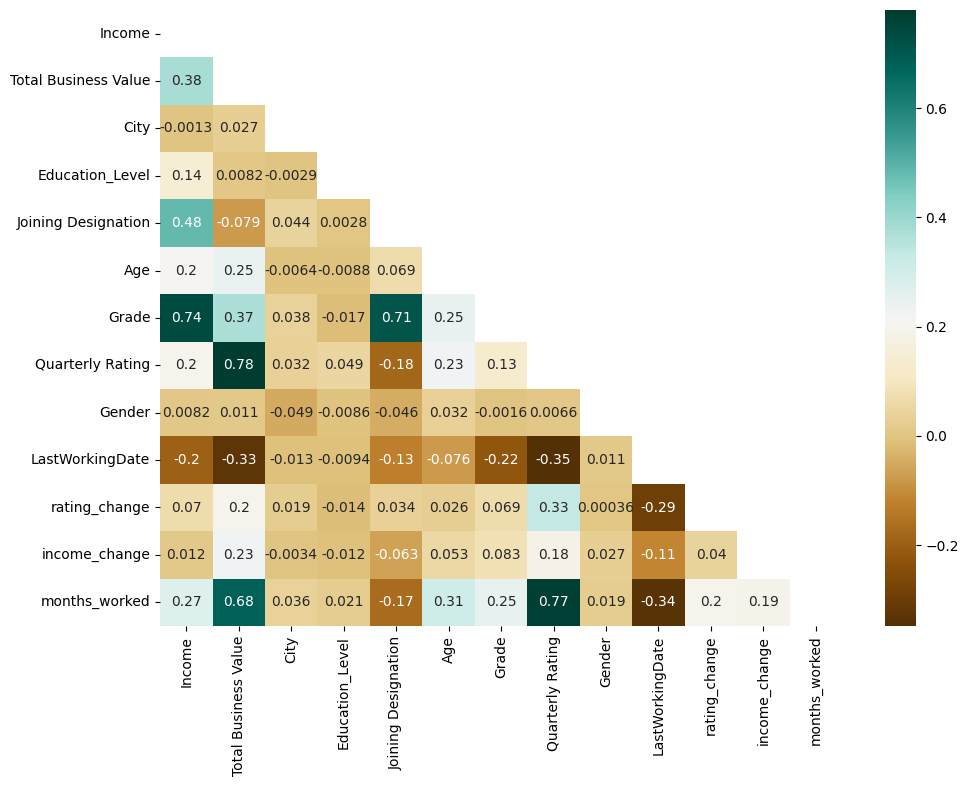

In [118]:
fig, ax = plt.subplots(figsize=(11,8))
sns.heatmap(modified_df.corr(), annot = True, cmap = 'BrBG', ax = ax, mask = np.triu(np.ones_like(modified_df.corr(), dtype=bool)))
plt.show()

### Data Preperation

In [119]:
global random_seed
random_seed = 42

In [120]:
modified_df.head()

,Income,Total Business Value,City,Education_Level,Joining Designation,Age,Grade,Quarterly Rating,Gender,LastWorkingDate,rating_change,income_change,months_worked
0,57387.0,571860.0,23,2.0,1.0,28.0,1.0,2.0,0.0,1,0,0,3.0
1,67016.0,0.0,7,2.0,2.0,31.0,2.0,1.0,0.0,0,0,0,2.0
2,65603.0,70000.0,13,2.0,2.0,43.0,2.0,1.0,0.0,1,0,0,6.0
3,46368.0,40120.0,9,0.0,1.0,29.0,1.0,1.0,0.0,1,0,0,3.0
4,78728.0,253000.0,11,1.0,3.0,31.0,3.0,2.0,1.0,0,1,0,6.0


In [121]:
cols = ["City", "Education_Level", "Gender", "Joining Designation", "Quarterly Rating", "rating_change", "income_change"]

display(modified_df[cols].nunique().reset_index())
display(modified_df.dtypes.reset_index())

,index,0
0,City,29
1,Education_Level,3
2,Gender,2
3,Joining Designation,5
4,Quarterly Rating,4
5,rating_change,2
6,income_change,2


,index,0
0,Income,float64
1,Total Business Value,float64
2,City,int64
3,Education_Level,float64
4,Joining Designation,float64
5,Age,float64
6,Grade,float64
7,Quarterly Rating,float64
8,Gender,float64
9,LastWorkingDate,int64


In [122]:
te = TargetEncoder()
te.fit(modified_df["City"].astype("category"),  modified_df["LastWorkingDate"])

modified_df["City"] = te.transform(modified_df["City"].astype("category"),  modified_df["LastWorkingDate"])

In [123]:
modified_df.head()

,Income,Total Business Value,City,Education_Level,Joining Designation,Age,Grade,Quarterly Rating,Gender,LastWorkingDate,rating_change,income_change,months_worked
0,57387.0,571860.0,0.766672,2.0,1.0,28.0,1.0,2.0,0.0,1,0,0,3.0
1,67016.0,0.0,0.684182,2.0,2.0,31.0,2.0,1.0,0.0,0,0,0,2.0
2,65603.0,70000.0,0.816050,2.0,2.0,43.0,2.0,1.0,0.0,1,0,0,6.0
3,46368.0,40120.0,0.706543,0.0,1.0,29.0,1.0,1.0,0.0,1,0,0,3.0
4,78728.0,253000.0,0.702800,1.0,3.0,31.0,3.0,2.0,1.0,0,1,0,6.0


In [124]:
modified_df.rename(columns = {"LastWorkingDate" : "churn"}, inplace = True)

In [125]:
X = modified_df.drop("churn", axis = 1).copy()
y = modified_df.churn.copy()

In [153]:
y.value_counts()

churn
1    1609
0     770
Name: count, dtype: int64

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = random_seed)

print(f"shape of the data ")
print("train: ")
print(f"  X_train = {X_train.shape}")
print(f"  y_train = {y_train.shape}")

print("test: ")
print(f"  X_test = {X_test.shape}")
print(f"  y_test = {y_test.shape}")


shape of the data 
train: 
  X_train = (1903, 12)
  y_train = (1903,)
test: 
  X_test = (476, 12)
  y_test = (476,)


In [127]:
y_train.value_counts(normalize = True)

churn
1    0.676301
0    0.323699
Name: proportion, dtype: float64

### Model

In [128]:
global scores
scores = {}

def model_score(model_name, y_true, y_pred):
    scores[model_name] = {"precession_score" : precision_score(y_true, y_pred), "recall_score" : recall_score(y_true, y_pred), "f1_score" : f1_score(y_true, y_pred)}

def metric_scores(actual, pred, data_type):
    print("-" * 70)
    print(f"{data_type} data results:")
    print(f"  accuracy_score = {accuracy_score(actual, pred)}")  
    print(f"  precision_score = {precision_score(actual, pred)}") 
    print(f"  recall_score = {recall_score(actual, pred)}") 
    print(f"  f1_score = {f1_score(actual, pred)}") 
    # print(classification_report(actual, pred))
    if data_type == "test":  
        print(f"  Confusion Matrix")
        conf = confusion_matrix(actual, pred)
        ConfusionMatrixDisplay(conf, display_labels = logisticRegression.classes_).plot()

def grid_search_cv(model, param_grid, scoring, X_train, y_train, folds):

    k_fold = KFold(n_splits = folds, shuffle = True, random_state = random_seed)

    grid_search = GridSearchCV(model, param_grid, cv = k_fold, scoring = scoring, n_jobs = -1) 
    grid_search.fit(X_train, y_train)
    
    print(f"best params = {grid_search.best_params_}")

    return grid_search.best_estimator_ 

##### Logistic Regression Model

In [129]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_sca = scaler.transform(X_train)
X_test_sca = scaler.transform(X_test)

In [130]:
logisticRegression = LogisticRegression()
logisticRegression.fit(X_train_sca, y_train)

LogisticRegression()

Scores for logistic regression model

----------------------------------------------------------------------
train data results:
  accuracy_score = 0.7708880714661062
  precision_score = 0.7816015883520847
  recall_score = 0.9176379176379177
  f1_score = 0.8441744102930666
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.7794117647058824
  precision_score = 0.7877984084880637
  recall_score = 0.922360248447205
  f1_score = 0.8497854077253219
  Confusion Matrix


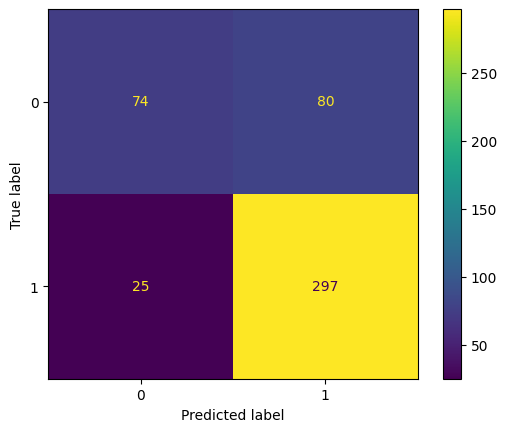

In [131]:
print(f"Scores for logistic regression model\n")
metric_scores(y_train, logisticRegression.predict(X_train_sca), data_type = "train")
metric_scores(y_test, logisticRegression.predict(X_test_sca), data_type = "test")

best params = {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
Scores for logistic regression model (hyper parameters tuned)

----------------------------------------------------------------------
train data results:
  accuracy_score = 0.7714135575407252
  precision_score = 0.7755498059508409
  recall_score = 0.9316239316239316
  f1_score = 0.8464525238263325
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.7752100840336135
  precision_score = 0.7806788511749347
  recall_score = 0.9285714285714286
  f1_score = 0.8482269503546099
  Confusion Matrix


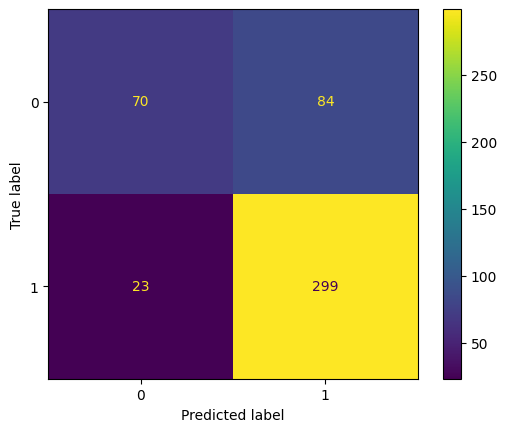

In [132]:
solvers = ["newton-cg", "lbfgs", "liblinear"]
penalty = ["l1", "l2", "elasticnet"]
c_values = [100, 10, 1.0, 0.1, 0.01]

param_grid = dict(solver = solvers, penalty = penalty, C = c_values)

logreg = grid_search_cv(LogisticRegression(random_state = random_seed, max_iter = 1000), param_grid, "accuracy", X_train_sca, y_train, folds = 10)
logreg.fit(X_train_sca, y_train)

print(f"Scores for logistic regression model (hyper parameters tuned)\n")
metric_scores(y_train, logreg.predict(X_train_sca), data_type = "train")
metric_scores(y_test, logreg.predict(X_test_sca), data_type = "test")

# best params = {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
# best params = {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}

In [133]:
model_score("Logistic Regression", y_test, logreg.predict(X_test_sca))

##### Decision Tree Model

In [134]:
decisionTreeClassifier = DecisionTreeClassifier()
decisionTreeClassifier.fit(X_train, y_train)

DecisionTreeClassifier()

Scores for Decision Tree Classifier model

----------------------------------------------------------------------
train data results:
  accuracy_score = 1.0
  precision_score = 1.0
  recall_score = 1.0
  f1_score = 1.0
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.7689075630252101
  precision_score = 0.8419354838709677
  recall_score = 0.8105590062111802
  f1_score = 0.8259493670886076
  Confusion Matrix


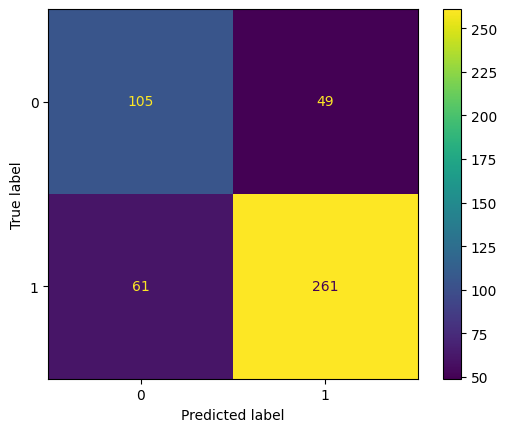

In [135]:
print(f"Scores for Decision Tree Classifier model\n")
metric_scores(y_train, decisionTreeClassifier.predict(X_train), data_type = "train")
metric_scores(y_test, decisionTreeClassifier.predict(X_test), data_type = "test")

best params = {'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'splitter': 'best'}

Scores for Decision Tree Classifier model (hyper parameters tuned)

----------------------------------------------------------------------
train data results:
  accuracy_score = 0.8018917498686284
  precision_score = 0.8172942817294282
  recall_score = 0.9106449106449106
  f1_score = 0.8614479970599045
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.8046218487394958
  precision_score = 0.806970509383378
  recall_score = 0.9347826086956522
  f1_score = 0.8661870503597122
  Confusion Matrix


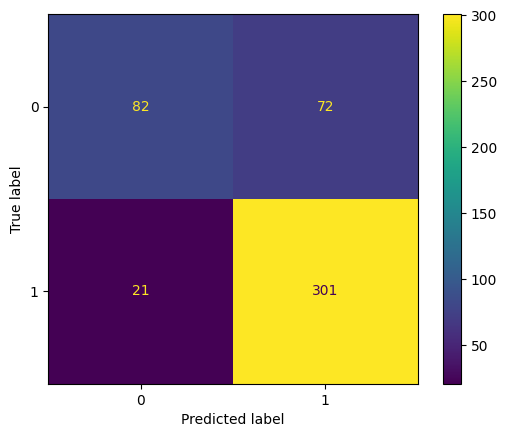

In [136]:
criterion = ["gini", "entropy", "log_loss"]
splitter = ["best"]
max_depth = [_ for _ in range(5,11,1)]
ccp_alpha = [.1, .01, .001]
max_features = ["sqrt", "log2"]
# max_leaf_nodes = [_ for _ in range(0,100)]
# min_samples_leaf = [_ for _ in range(0,100)]

param_grid = dict(criterion = criterion,splitter = splitter,max_depth = max_depth, ccp_alpha = ccp_alpha, max_features = max_features)

decisionTreeClassifier = grid_search_cv(DecisionTreeClassifier(random_state = random_seed), param_grid, "accuracy", X_train, y_train, folds = 5)
decisionTreeClassifier.fit(X_train, y_train)

print(f"\nScores for Decision Tree Classifier model (hyper parameters tuned)\n")
metric_scores(y_train, decisionTreeClassifier.predict(X_train), data_type = "train")
metric_scores(y_test, decisionTreeClassifier.predict(X_test), data_type = "test")

# best params = {'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'splitter': 'best'}

In [137]:
model_score("Decision Tree Classifier", y_test, decisionTreeClassifier.predict(X_test))

#### Bagging - RandomForestClassifier model

In [138]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, y_train)

RandomForestClassifier()

Scores for RandomForest Classifier model

----------------------------------------------------------------------
train data results:
  accuracy_score = 1.0
  precision_score = 1.0
  recall_score = 1.0
  f1_score = 1.0
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.8046218487394958
  precision_score = 0.8154269972451791
  recall_score = 0.9192546583850931
  f1_score = 0.8642335766423357
  Confusion Matrix


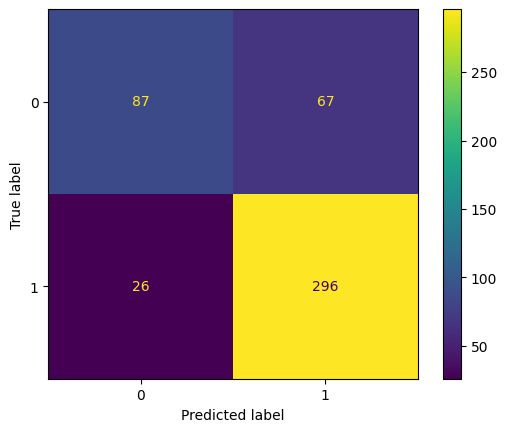

In [139]:
print(f"Scores for RandomForest Classifier model\n")
metric_scores(y_train, rfc_model.predict(X_train), data_type = "train")
metric_scores(y_test, rfc_model.predict(X_test), data_type = "test")

In [152]:
grid = {
    'n_estimators': [val for val in range (100,1001, 100)],
    'max_features': ['sqrt','log2'],
    'max_depth' : [val for val in range (3,11)]
}

rfc_model = grid_search_cv(RandomForestClassifier(random_state = random_seed), grid, "accuracy", X_train, y_train, folds = 5)
rfc_model.fit(X_train, y_train)

# best params = {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 900}

best params = {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 900}


RandomForestClassifier(max_depth=10, n_estimators=900, random_state=42)


Scores for RandomForest Classifier model (hyper parameters tuned)

----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9196006305832896
  precision_score = 0.8965034965034965
  recall_score = 0.9961149961149961
  f1_score = 0.9436878910563121
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.8151260504201681
  precision_score = 0.8162162162162162
  recall_score = 0.937888198757764
  f1_score = 0.8728323699421965
  Confusion Matrix


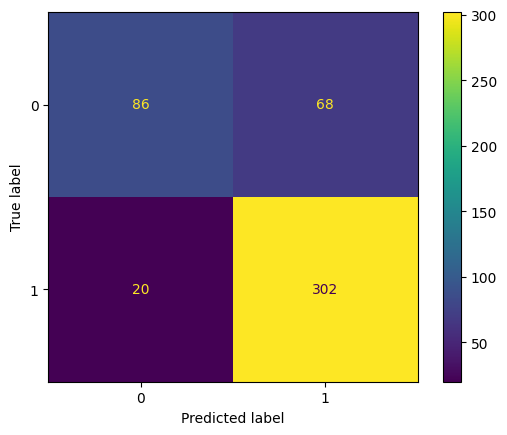

In [141]:
print(f"\nScores for RandomForest Classifier model (hyper parameters tuned)\n")
metric_scores(y_train, rfc_model.predict(X_train), data_type = "train")
metric_scores(y_test, rfc_model.predict(X_test), data_type = "test")

In [158]:
roc_auc_score(y_test, rfc_model.predict(X_test))

0.7481648785996613

In [144]:
model_score("RandomForest Classifier", y_test, rfc_model.predict(X_test))

#### Boosting GDBTClassifier

In [145]:
gdbt_model = GradientBoostingClassifier()
gdbt_model.fit(X_train, y_train)

GradientBoostingClassifier()

Scores for GradientBoosting Classifier model

----------------------------------------------------------------------
train data results:
  accuracy_score = 0.86022070415134
  precision_score = 0.8542678695350451
  recall_score = 0.9564879564879565
  f1_score = 0.902492668621701
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.8340336134453782
  precision_score = 0.8292682926829268
  recall_score = 0.9503105590062112
  f1_score = 0.8856729377713459
  Confusion Matrix


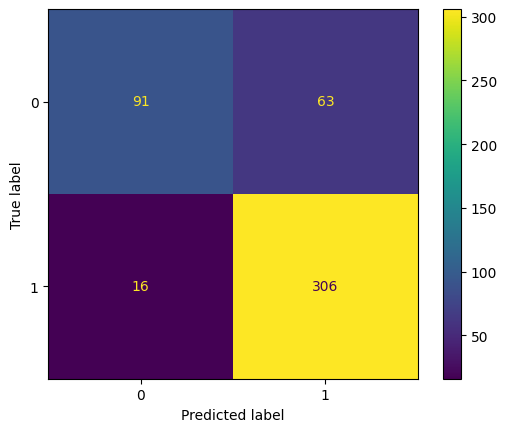

In [146]:
print(f"Scores for GradientBoosting Classifier model\n")
metric_scores(y_train, gdbt_model.predict(X_train), data_type = "train")
metric_scores(y_test, gdbt_model.predict(X_test), data_type = "test")

In [151]:
param_grid = {
    'n_estimators': [val for val in range (100,1001, 100)],
    # 'max_features': ['sqrt','log2'],
    'max_depth' : [val for val in range (3,11)],
    # "min_samples_split" : [val for val in range(1,10,1)],
    # "min_samples_leaf" : [val for val in range(1,10,1)],
    "max_depth" : [val for val in range(1,10,1)],
    "booster" : ["gbtree", "gblinear"],
    "eta" : [.001,0.01,0.2,0.1,1,10]
}

xgboost = grid_search_cv(XGBClassifier(random_state = random_seed), param_grid, "accuracy", X_train, y_train, folds = 5)
xgboost.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print(f"\nScores for GradientBoosting Classifier model (hyper parameters tuned)\n")
metric_scores(y_train, gdbt_model.predict(X_train), data_type = "train")
metric_scores(y_test, gdbt_model.predict(X_test), data_type = "test")

In [ ]:
model_score("GradientBoosting Classifier", y_test, gdbt_model.predict(X_test))

In [ ]:
scores

### EDA

,Income,Total Business Value
City,,
C13,62173.028120,796263.075571
C29,67847.282222,736637.511111
C12,71676.976616,667282.310867
C26,67186.544304,661837.445339
C5,74745.911585,634855.975610
C16,63141.394922,632585.712271
C19,70735.860104,630978.151986


<Axes: xlabel='City'>

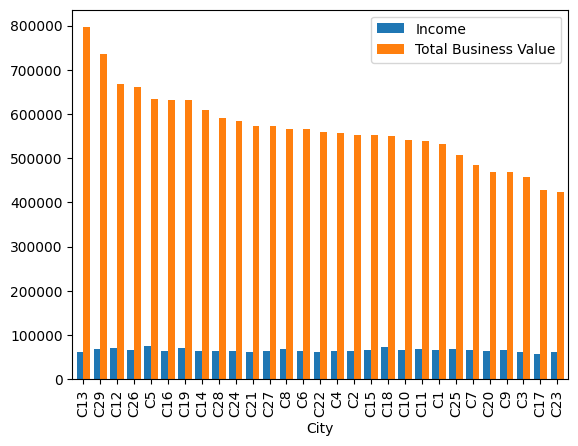

In [142]:
cities_income = df.groupby(by = "City").agg({"Income" : "mean", "Total Business Value" : "mean"}).sort_values(by = ["Total Business Value", "Income"], ascending = False)
display(cities_income.iloc[0:7, :])

cities_income.plot(kind = "bar", position = 0.5, width = 0.8)

<Axes: xlabel='Education_Level'>

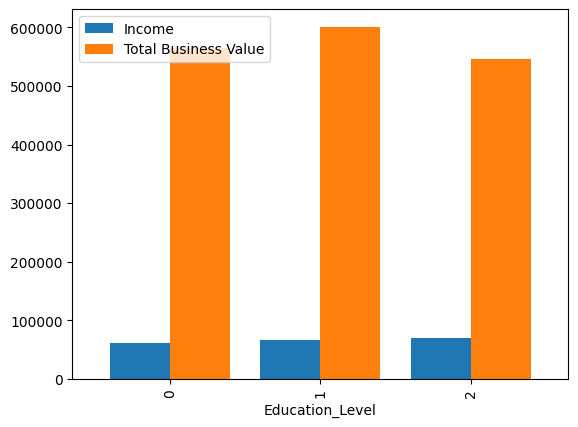

In [143]:
df.groupby(by = "Education_Level").agg({"Income" : "mean", "Total Business Value" : "mean"}).plot(kind = "bar", position = 0.5, width = 0.8)